In [55]:
import jupyter_black

jupyter_black.load()

In [56]:
import pandas as pd
from pyfaidx import Fasta

fasta_ms_path = "../data/tolip/signalp/processed_entries.fasta"
fasta_ms = Fasta(fasta_ms_path, key_function=lambda x: x.split("_")[0])
df = pd.read_csv("../data/online_version/submission_data.csv")
df_tolip = pd.read_csv("../data/tolip/protein-matching-IPR035076.tsv", sep="\t")
df["uid"] = df["identifier"].str.split("|").str[1]
df.head(2)

,identifier,group,major_group,membrane_prediction,taxon_of_interest,family,genus,species,taxon_id,db,uniprot_id,uniprot_entry,genbank_id,refseq_id,gi_number,in_tree,seq_start,full_seq,mature_seq,uid
0,None|Xetr_1|Xenopus_tropicalis,frog Ly6,Ly-6,Membrane,Anura,Pipidae,Xenopus,Xenopus tropicalis,8364,NaN,NaN,NaN,NaN,NaN,NaN,yes,MAA,MAALYISLLLAALCIGTAVPLRCYTCTGATNANCLTQTDCGSTNTS...,LRCYTCTGATNANCLTQTDCGSTNTSCATVVGSVLGQPIIIKSCTL...,Xetr_1
1,None|Xetr_2|Xenopus_tropicalis,frog Ly6,Ly-6,Secreted,Anura,Pipidae,Xenopus,Xenopus tropicalis,8364,NaN,NaN,NaN,NaN,NaN,NaN,yes,MQC,MQCYMCLGATSNANCLTPTTCRSYDAYCQTVSSASITKYCAPSCTP...,MQCYMCLGATSNANCLTPTTCRSYDAYCQTVSSASITKYCAPSCTP...,Xetr_2


<Axes: >

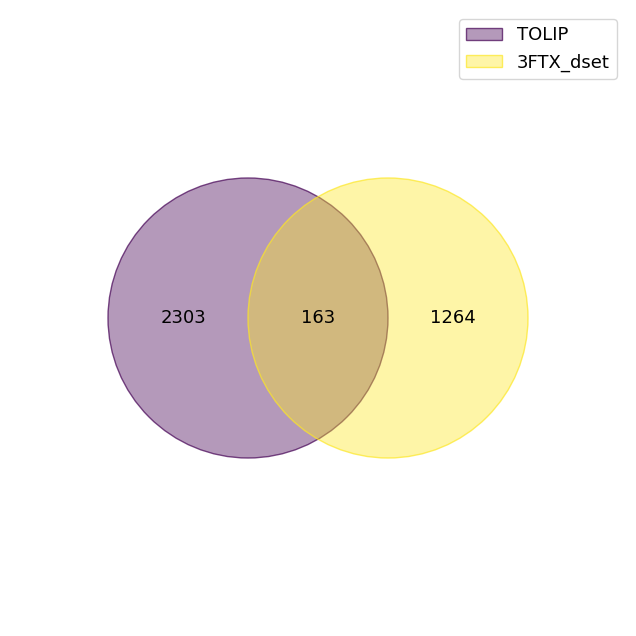

In [57]:
from venn import venn

data = {
    "TOLIP": set(df_tolip.loc[df_tolip["Source Database"] == "reviewed", "Accession"]),
    "3FTX_dset": set(df["uid"]),
}
data = {"TOLIP": set(df_tolip["Accession"]), "3FTX_dset": set(df["uid"])}
venn(data=data)

In [65]:
data = list()
uids_3ftx = set(df["uid"])
for idx, row in df_tolip.iterrows():
    if row["Accession"] not in uids_3ftx:
        data.append(row)

new_data = pd.concat(data, axis=1).transpose()
new_data["identifier"] = (
    "InterPro|"
    + new_data["Entry Accession"]
    + "_"
    + new_data["Accession"]
    + "|"
    + new_data["Tax Name"].str.replace(" ", "_")
)
new_data = new_data.rename(
    columns={
        "Accession": "uniprot_id",
        "Name": "major_group",
        "Tax ID": "taxon_id",
        "Tax Name": "species",
        "Entry Accession": "InterPro_id",
    }
)
new_data = new_data.drop(columns=["Source Database", "Length", "Matches"])

# filter fasta and save as new fasta
with open("../data/tolip/ms_new_tolip.fasta", "w") as handle:
    for header, seq in fasta_ms.items():
        uid = new_data.loc[new_data["uniprot_id"] == header, "identifier"].to_list()
        if not uid:
            continue
        handle.write(f">{uid[0]}\n")
        handle.write(f"{seq}\n")

# --- save TOLIP ---
new_data = new_data[
    [
        "identifier",
        "major_group",
        "taxon_id",
        "species",
        "uniprot_id",
        "InterPro_id",
    ]
]
new_data.to_csv("../data/tolip/tolip.csv", index=False)
new_data = pd.concat([df, new_data])
new_data.to_csv("../data/tolip/tolip_merged.csv", index=False)
new_data.head(2)

,identifier,group,major_group,membrane_prediction,taxon_of_interest,family,genus,species,taxon_id,db,...,uniprot_entry,genbank_id,refseq_id,gi_number,in_tree,seq_start,full_seq,mature_seq,uid,InterPro_id
0,None|Xetr_1|Xenopus_tropicalis,frog Ly6,Ly-6,Membrane,Anura,Pipidae,Xenopus,Xenopus tropicalis,8364,NaN,...,NaN,NaN,NaN,NaN,yes,MAA,MAALYISLLLAALCIGTAVPLRCYTCTGATNANCLTQTDCGSTNTS...,LRCYTCTGATNANCLTQTDCGSTNTSCATVVGSVLGQPIIIKSCTL...,Xetr_1,NaN
1,None|Xetr_2|Xenopus_tropicalis,frog Ly6,Ly-6,Secreted,Anura,Pipidae,Xenopus,Xenopus tropicalis,8364,NaN,...,NaN,NaN,NaN,NaN,yes,MQC,MQCYMCLGATSNANCLTPTTCRSYDAYCQTVSSASITKYCAPSCTP...,MQCYMCLGATSNANCLTPTTCRSYDAYCQTVSSASITKYCAPSCTP...,Xetr_2,NaN


## merge HDF5 files

In [54]:
import h5py

hdf_3ftx = "../data/protspace_after_ivan_manual_bmul/3FTx_prott5.h5"
hdf_tolip = "../data/tolip/ms_new_tolip_prott5.h5"
hdf_merged = "../data/tolip/tolip_merged.h5"

with h5py.File(hdf_3ftx, "r") as in1, h5py.File(hdf_tolip, "r") as in2, h5py.File(
    hdf_merged, "w"
) as out:
    for handler in [in1, in2]:
        for header, emb in handler.items():
            out.create_dataset(name=header, data=emb)